Step 1: Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Step 2: Removing Corrupted Images


In [ ]:
import os
from PIL import Image

def check_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Bad file: {file_path}")
                os.remove(file_path)

dataset_path = '/content/drive/MyDrive/food_dataset_neww'
check_images(dataset_path)


Step 3: Data Preprocessing


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    subset='training',
    shuffle=True
)

validation_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    subset='validation',
    shuffle=True
)

print(train_gen.class_indices)
print(validation_gen.class_indices)


Found 54 images belonging to 8 classes.
Found 19 images belonging to 8 classes.
{'Chapathi': 0, 'Dal Chawal': 1, 'Dosa': 2, 'Fruits': 3, 'Fryms': 4, 'Panner Tikka Masala': 5, 'Poriyal': 6, 'Rice': 7}
{'Chapathi': 0, 'Dal Chawal': 1, 'Dosa': 2, 'Fruits': 3, 'Fryms': 4, 'Panner Tikka Masala': 5, 'Poriyal': 6, 'Rice': 7}


Step 4: Model Creation with Transfer Learning


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

reference_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the layers
for layer in reference_model.layers:
    layer.trainable = False

model = models.Sequential([
    reference_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=20, activation='softmax')
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Step 5: Model Compilation and Training


In [ ]:
print("Number of classes found:", len(train_gen.class_indices))
print("Class indices:", train_gen.class_indices)

Number of classes found: 8
Class indices: {'Chapathi': 0, 'Dal Chawal': 1, 'Dosa': 2, 'Fruits': 3, 'Fryms': 4, 'Panner Tikka Masala': 5, 'Poriyal': 6, 'Rice': 7}


In [ ]:
import os
from PIL import Image
import imghdr
from tqdm import tqdm

def remove_corrupted_images(directory):
    print("Checking for corrupted images...")
    corrupted_count = 0

    for root, _, files in tqdm(list(os.walk(directory))):
        for file in files:
            file_path = os.path.join(root, file)

            # Skip non-image files
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue

            # Check if file is a valid image
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify the image
                    # Try to load it completely
                    img = Image.open(file_path)
                    img.load()
            except (IOError, SyntaxError, OSError) as e:
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)
                corrupted_count += 1

    print(f"Removed {corrupted_count} corrupted images")

# Run this function on your dataset
remove_corrupted_images(dataset_path)

<ipython-input-6-52e0c15798e6>:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Checking for corrupted images...


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]

Removed 0 corrupted images


In [ ]:
# Recreate the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    subset='training',
    shuffle=True
)

validation_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    subset='validation',
    shuffle=True
)

# Check the number of classes again
num_classes = len(train_gen.class_indices)
print(f"Number of classes after cleaning: {num_classes}")
print(f"Class indices: {train_gen.class_indices}")

Found 54 images belonging to 8 classes.
Found 19 images belonging to 8 classes.
Number of classes after cleaning: 8
Class indices: {'Chapathi': 0, 'Dal Chawal': 1, 'Dosa': 2, 'Fruits': 3, 'Fryms': 4, 'Panner Tikka Masala': 5, 'Poriyal': 6, 'Rice': 7}


In [ ]:
# Recreate the model with the correct number of classes
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint # Import ModelCheckpoint
model = models.Sequential([
    reference_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up the checkpoint callback
os.makedirs('/content/drive/MyDrive/saved_model/', exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/saved_model/model_epoch_{epoch:02d}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model with a try-except block to handle any remaining issues
try:
    trained_model = model.fit(
        train_gen,
        epochs=10,
        validation_data=validation_gen,
        callbacks=[checkpoint_callback]
    )
except Exception as e:
    print(f"Error during training: {e}")
    # If there's still an error, we might need a more robust approach

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3274 - loss: 2.1831
Epoch 1: val_accuracy improved from -inf to 0.73684, saving model to /content/drive/MyDrive/saved_model/model_epoch_01.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.3911 - loss: 1.9804 - val_accuracy: 0.7368 - val_loss: 2.6835
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1088
Epoch 2: val_accuracy did not improve from 0.73684
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.0000 - loss: 0.1112 - val_accuracy: 0.7368 - val_loss: 2.5613
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 1.0000 - loss: 0.0527
Epoch 3: val_accuracy improved from 0.73684 to 0.78947, saving model to /content/drive/MyDrive/saved_model/model_epoch_03.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 10s/step - accuracy: 1.0000 - loss: 0.0541 - val_accuracy: 0.7895 - val_loss: 2.0714
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0433  
Epoch 4: val_accuracy did not improve from 0.78947
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 1.0000 - loss: 0.0435 - val_accuracy: 0.7895 - val_loss: 1.6128
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0287
Epoch 5: val_accuracy did not improve from 0.78947
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 1.0000 - loss: 0.0308 - val_accuracy: 0.7895 - val_loss: 1.3016
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0304
Epoch 6: val_accuracy improved from 0.78947 to 0.84211, saving model to /content/drive/MyDrive/saved_model/model_epoch_06.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 11s/step - accuracy: 1.0000 - loss: 0.0304 - val_accuracy: 0.8421 - val_loss: 1.1063
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0171
Epoch 7: val_accuracy did not improve from 0.84211
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 1.0000 - loss: 0.0174 - val_accuracy: 0.8421 - val_loss: 0.9510
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0121
Epoch 8: val_accuracy did not improve from 0.84211
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.8421 - val_loss: 0.8377
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0151
Epoch 9: val_accuracy did not improve from 0.84211
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.8421 - val_loss: 0.7511
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0244
Epoch 10: val_accuracy did not improve from 0.84211
2/2 ━━━━━━━━━━━━━━━━

Step 6: Fine-tuning the Model


In [ ]:
# Unfreezing some layers
for layer in reference_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Step 7: Saving the Final Model


In [ ]:
saved_model = model.save('/content/drive/MyDrive/saved_model/final.keras')


Step 8: Loading the Model and Making Predictions


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Function to predict images
def predict_image(image_path, saved_model):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = saved_model.predict(img)

    # Updated list with all 35 classes
    classes = ['Chapathi', 'Dal Chawal', 'Dosa', 'Fruits', 'Fryms', 'Panner Tikka Masala', 'Poriyal', 'Rice']

    predicted_class = classes[np.argmax(prediction)]

    # Print additional information for debugging
    class_index = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    print(f"Predicted class index: {class_index}")
    print(f"Confidence: {confidence:.2f}%")

    return predicted_class

# Load the model and make a prediction
saved_model = load_model('/content/drive/MyDrive/saved_model/final.keras')
#image_path = '/content/Dosa/1.jpg'
#predicted_class = predict_image(image_path, saved_model)
#print(f"Predicted dish: {predicted_class}")

Step 9: Model Evaluation


In [ ]:
from sklearn.metrics import classification_report

y_predict = model.predict(validation_gen)
y_true = validation_gen.classes

print(classification_report(y_true, y_predict.argmax(axis=1)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1
           3       0.25      0.50      0.33         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       0.25      0.20      0.22         5

    accuracy                           0.26        19
   macro avg       0.24      0.26      0.24        19
weighted avg       0.25      0.26      0.25        19



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 10: Plotting Training and Validation Loss/Accuracy


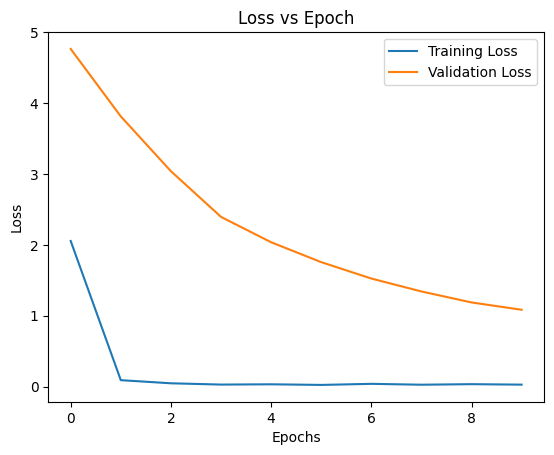

In [ ]:
import matplotlib.pyplot as plt

training_loss = trained_model.history['loss']
test_loss = trained_model.history['val_loss']
training_acc = trained_model.history['accuracy']
test_acc = trained_model.history['val_accuracy']
epochs = range(len(training_loss))

plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, test_loss, label='Validation Loss')
plt.legend()
plt.show()


**11: Interactive Food Analysis and Waste Reduction Recommendations**


===== AUTOMATED FOOD WASTE ANALYSIS SYSTEM =====
Enter the path to the folder containing food images: /content/new
Found 11 images. Processing...


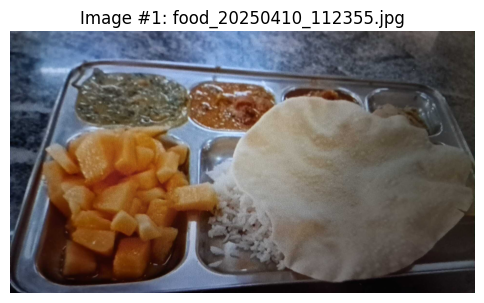

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class index: 2
Confidence: 59.79%
Image 1/11: food_20250410_112355.jpg - Detected food: Dosa


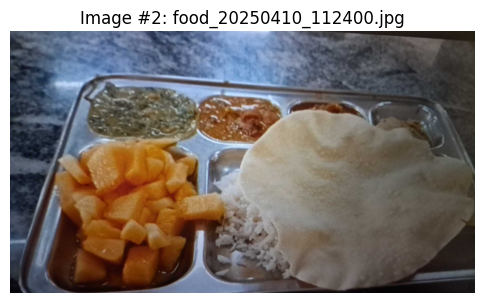

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted class index: 2
Confidence: 54.23%
Image 2/11: food_20250410_112400.jpg - Detected food: Dosa


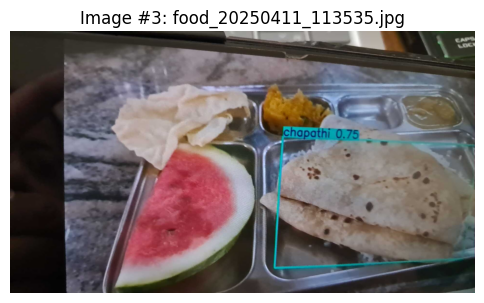

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted class index: 0
Confidence: 93.96%
Image 3/11: food_20250411_113535.jpg - Detected food: Chapathi


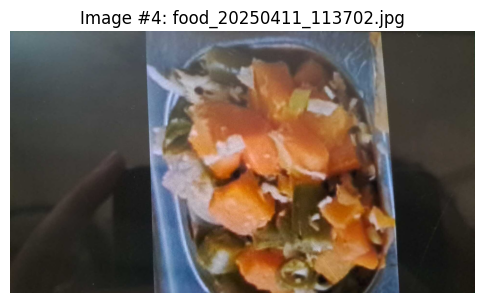

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted class index: 3
Confidence: 67.26%
Image 4/11: food_20250411_113702.jpg - Detected food: Fruits


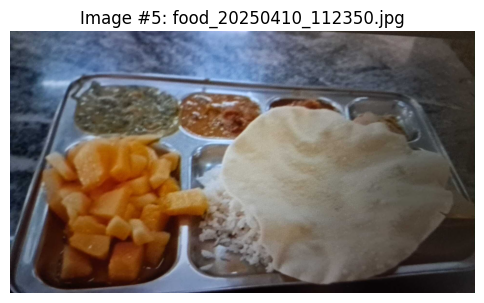

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted class index: 4
Confidence: 89.98%
Image 5/11: food_20250410_112350.jpg - Detected food: Fryms


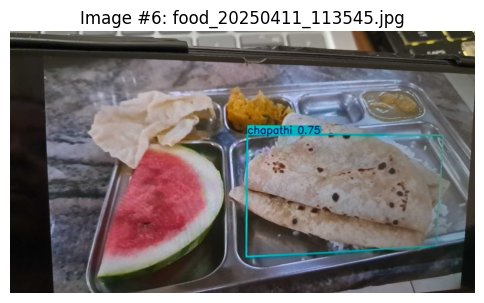

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted class index: 0
Confidence: 99.23%
Image 6/11: food_20250411_113545.jpg - Detected food: Chapathi


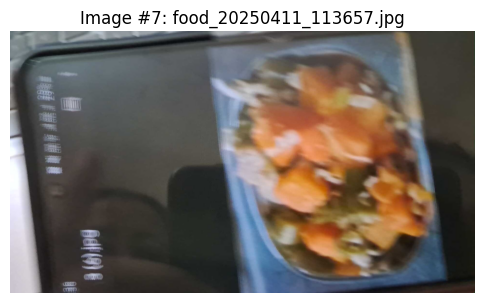

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted class index: 6
Confidence: 52.78%
Image 7/11: food_20250411_113657.jpg - Detected food: Poriyal


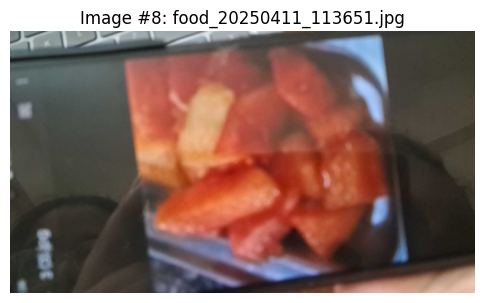

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted class index: 6
Confidence: 84.60%
Image 8/11: food_20250411_113651.jpg - Detected food: Poriyal


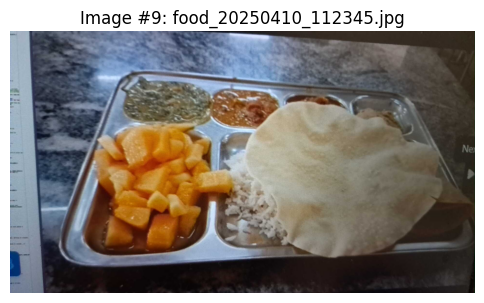

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted class index: 2
Confidence: 74.34%
Image 9/11: food_20250410_112345.jpg - Detected food: Dosa


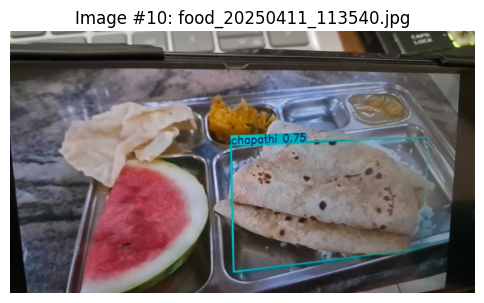

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted class index: 0
Confidence: 99.46%
Image 10/11: food_20250411_113540.jpg - Detected food: Chapathi


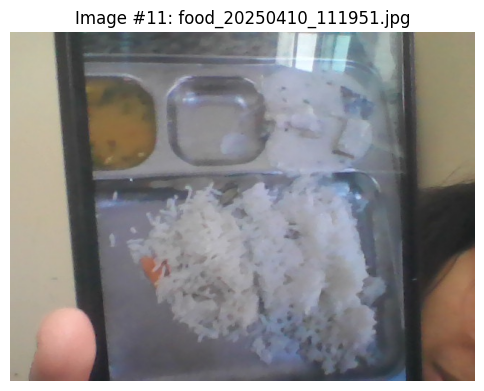

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted class index: 3
Confidence: 66.53%
Image 11/11: food_20250410_111951.jpg - Detected food: Fruits

===== FOOD ANALYSIS RESULTS =====


,Food Type,Count (%),Estimated Waste (%),Recommended Reduction (%)
0,Dosa,27.3,25,20
1,Chapathi,27.3,25,20
2,Fruits,18.2,15,10
4,Poriyal,18.2,15,10
3,Fryms,9.1,5,0


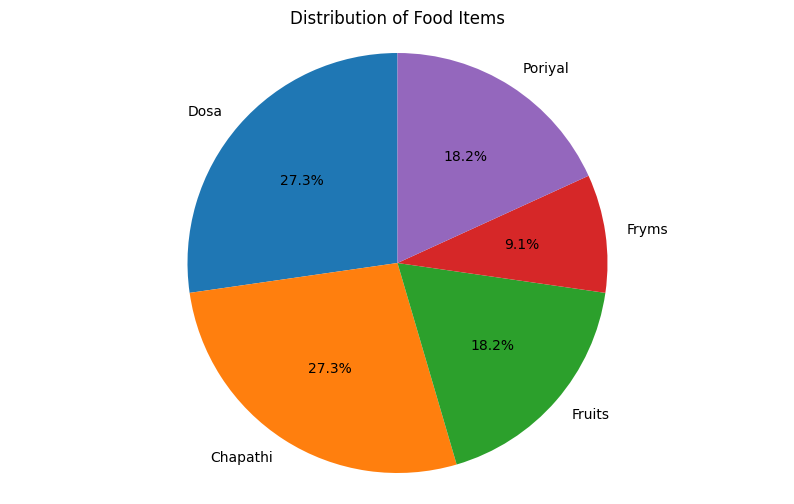

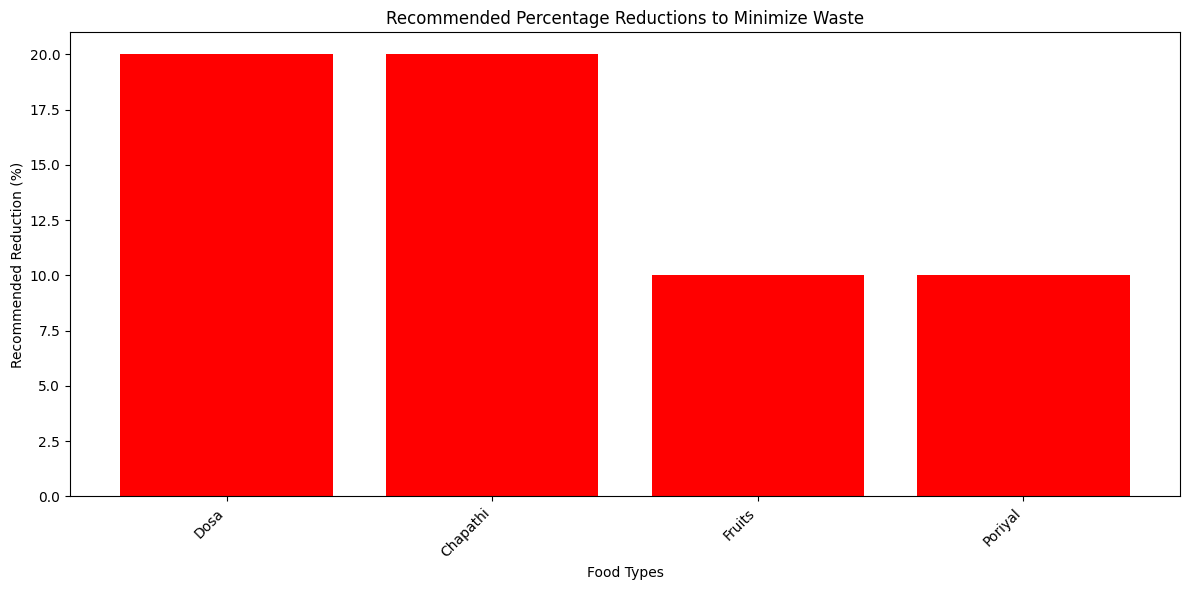


===== WASTE REDUCTION RECOMMENDATIONS =====
Based on your food image analysis, we recommend:
- Dosa: Estimated waste 25%
  Recommendation: Reduce by 20% in future meal planning
- Chapathi: Estimated waste 25%
  Recommendation: Reduce by 20% in future meal planning
- Fruits: Estimated waste 15%
  Recommendation: Reduce by 10% in future meal planning
- Poriyal: Estimated waste 15%
  Recommendation: Reduce by 10% in future meal planning

Implementing these recommendations could reduce overall food waste by approximately 16.0%

===== RESOURCE SAVINGS AND FINANCIAL BENEFITS =====

Daily Resource Savings by Food Type:


,Food Type,Daily Servings Reduced,Water Saved (L/day),Carbon Reduced (kg CO2/day),Energy Saved (kWh/day),Cost Saved (INR/day)
0,Dosa,54.6,65520.0,43.68,54.60,1911.0
1,Chapathi,54.6,81900.0,81.90,54.60,1911.0
2,Fruits,18.2,14560.0,5.46,7.28,455.0
3,Poriyal,18.2,7280.0,9.10,12.74,546.0



Total Resource Savings Summary:
Daily Savings:
  - Water: 169260.0 liters
  - Carbon Emissions: 140.14 kg CO2
  - Energy: 129.22 kWh
  - Cost: ₹4823.00

Monthly Savings:
  - Water: 5077800.0 liters
  - Carbon Emissions: 4204.20 kg CO2
  - Energy: 3876.60 kWh
  - Cost: ₹144690.00

Yearly Savings:
  - Water: 60933600.0 liters (60933.6 cubic meters)
  - Carbon Emissions: 50450.40 kg CO2 (50.45 metric tons)
  - Energy: 46519.20 kWh
  - Cost: ₹1736280.00 (₹17.36 lakhs)


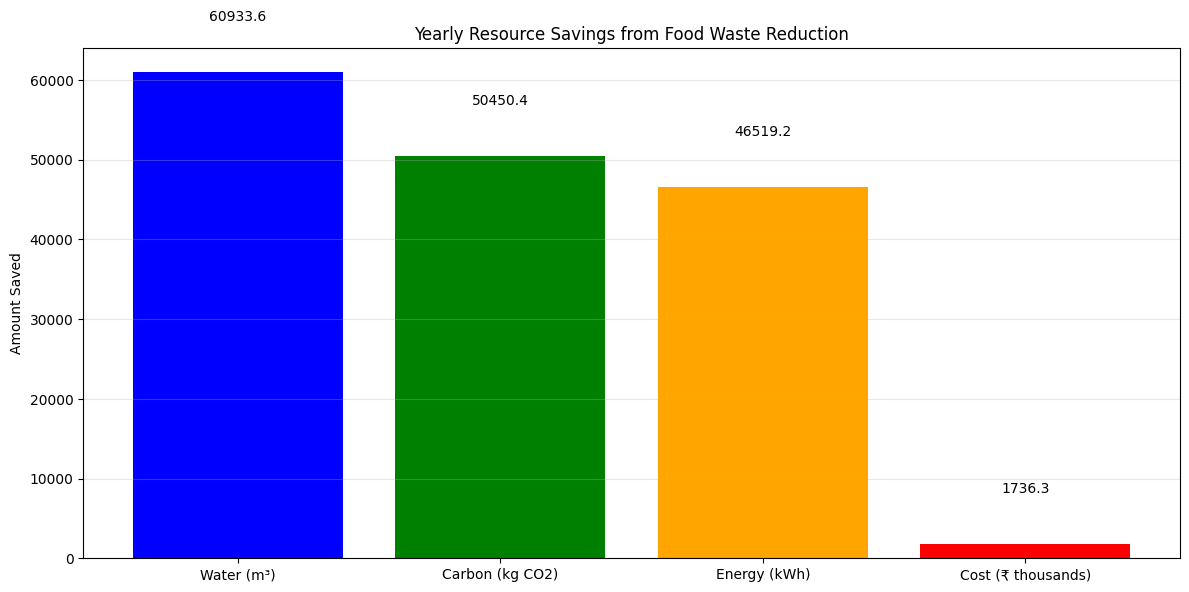

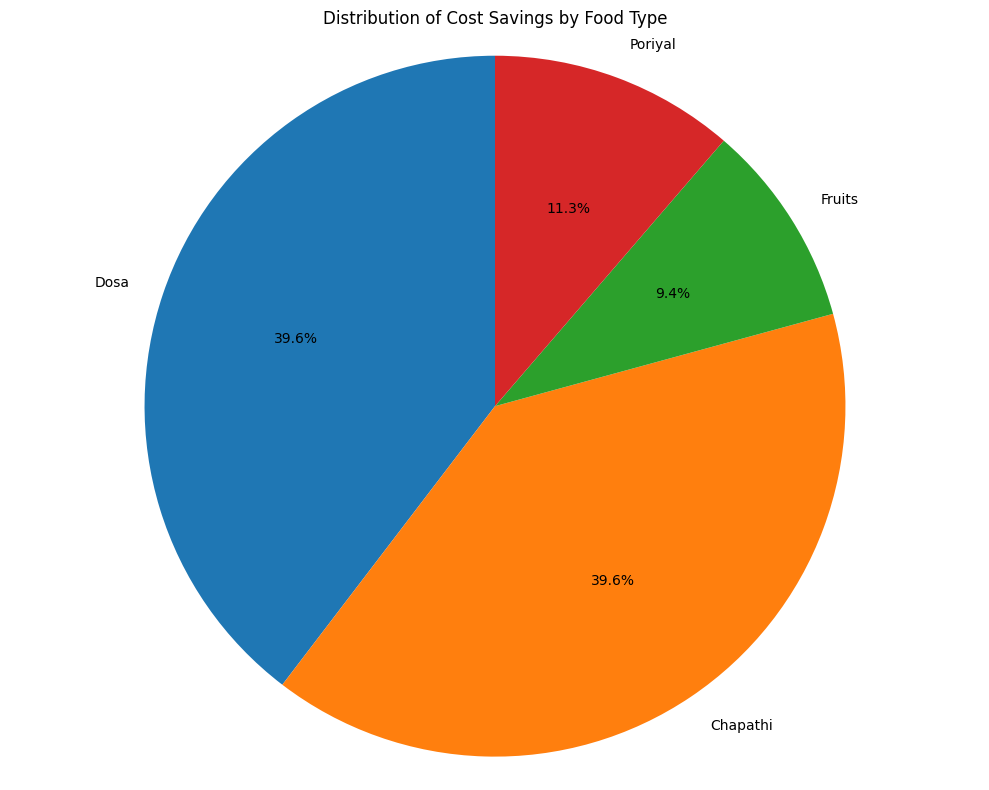


Contextualizing the Yearly Savings:
The water saved could meet the daily needs of 406224 people for one day.
The carbon reduction is equivalent to planting 2018 trees.
The energy saved could power 51 homes for a month.
The cost savings could fund 347 additional scholarship meals per year (at ₹5000 per semester).

Thank you for using the Automated Food Waste Analysis System!


In [ ]:
# Add this at the end of the file after the existing code

"""Step 11: Automated Food Analysis and Waste Reduction Recommendations from Folder"""

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image as PILImage
import os

def automated_food_waste_analysis():
    # Dictionary to store food counts
    food_counts = {}

    print("===== AUTOMATED FOOD WASTE ANALYSIS SYSTEM =====")
    folder_path = input("Enter the path to the folder containing food images: ")

    if not os.path.exists(folder_path) or not os.path.isdir(folder_path):
        print(f"Error: The path '{folder_path}' does not exist or is not a directory.")
        return

    # Get all jpg and jpeg files from the directory
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))]

    if not image_files:
        print(f"No JPG or JPEG images found in '{folder_path}'.")
        return

    print(f"Found {len(image_files)} images. Processing...")

    # Process each image
    for i, image_file in enumerate(image_files, 1):
        image_path = os.path.join(folder_path, image_file)

        try:
            # Display the image
            img = PILImage.open(image_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image #{i}: {image_file}")
            plt.show()

            # Predict the food type
            predicted_food = predict_image(image_path, saved_model)
            print(f"Image {i}/{len(image_files)}: {image_file} - Detected food: {predicted_food}")

            # Store the information
            if predicted_food in food_counts:
                food_counts[predicted_food] += 1
            else:
                food_counts[predicted_food] = 1

        except Exception as e:
            print(f"Error processing image {image_file}: {e}")

    if not food_counts:
        print("No food items could be successfully analyzed.")
        return

    # Calculate total items
    total_items = sum(food_counts.values())

    # Calculate waste percentages
    results = []

    for food, count in food_counts.items():
        percentage = (count / total_items) * 100

        # Waste estimation logic
        # Higher frequency might indicate potential for waste
        if percentage > 30:  # If any food type is more than 30% of total
            waste_percentage = 40  # High waste potential
            reduction_percentage = 30  # Suggest reducing by 30%
        elif percentage > 20:  # If food type is 20-30% of total
            waste_percentage = 25  # Medium waste potential
            reduction_percentage = 20  # Suggest reducing by 20%
        elif count > 1:  # If more than 1 instance of same food
            waste_percentage = 15  # Low waste potential
            reduction_percentage = 10  # Suggest reducing by 10%
        else:
            waste_percentage = 5  # Minimal waste potential
            reduction_percentage = 0  # No reduction needed

        # Calculate recommended reduction as percentage of the total count
        recommended_reduction_percent = reduction_percentage

        results.append({
            'Food Type': food,
            'Count (%)': round(percentage, 1),
            'Estimated Waste (%)': waste_percentage,
            'Recommended Reduction (%)': recommended_reduction_percent
        })

    # Create and display the results dataframe
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values('Count (%)', ascending=False)

    print("\n===== FOOD ANALYSIS RESULTS =====")
    display(df_results)

    # Generate pie chart of food distribution
    plt.figure(figsize=(10, 6))
    plt.pie([count for count in food_counts.values()],
            labels=food_counts.keys(),
            autopct='%1.1f%%',
            startangle=90)
    plt.axis('equal')
    plt.title('Distribution of Food Items')
    plt.show()

    # Generate bar chart for recommended reductions
    plt.figure(figsize=(12, 6))
    foods = [row['Food Type'] for row in results if row['Recommended Reduction (%)'] > 0]
    reductions = [row['Recommended Reduction (%)'] for row in results if row['Recommended Reduction (%)'] > 0]

    if foods and reductions:
        plt.bar(foods, reductions, color='red')
        plt.xlabel('Food Types')
        plt.ylabel('Recommended Reduction (%)')
        plt.title('Recommended Percentage Reductions to Minimize Waste')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Print waste reduction recommendations
    print("\n===== WASTE REDUCTION RECOMMENDATIONS =====")

    # Filter out items with no recommended reduction
    recommendations = [row for row in results if row['Recommended Reduction (%)'] > 0]

    if recommendations:
        print("Based on your food image analysis, we recommend:")

        for rec in recommendations:
            food = rec['Food Type']
            reduction_pct = rec['Recommended Reduction (%)']
            waste_pct = rec['Estimated Waste (%)']

            if reduction_pct > 0:
                print(f"- {food}: Estimated waste {waste_pct}%")
                print(f"  Recommendation: Reduce by {reduction_pct}% in future meal planning")

        # Calculate overall potential waste reduction
        # Using weighted average based on food percentages
        total_percentage = sum(rec['Count (%)'] for rec in recommendations)
        weighted_reduction = sum(rec['Count (%)'] * rec['Recommended Reduction (%)'] for rec in recommendations) / total_percentage if total_percentage > 0 else 0

        print(f"\nImplementing these recommendations could reduce overall food waste by approximately {weighted_reduction:.1f}%")
    else:
        print("Your food distribution appears to be well-balanced. No specific reduction recommendations at this time.")


# Add this to the automated_food_waste_analysis function before the final print statement

    # Calculate resource savings and financial benefits
    print("\n===== RESOURCE SAVINGS AND FINANCIAL BENEFITS =====")

    # Define resource factors for different food types (per unit of food)
    # These are example values - replace with actual data for your specific context
    resource_factors = {
        # Format: {food_type: (water_liters, carbon_kg, energy_kWh, cost_inr)}
        'Rice': (2500, 2.7, 1.5, 40),  # Water (L), Carbon (kg CO2), Energy (kWh), Cost (INR)
        'Dal': (1800, 1.2, 0.8, 35),
        'Chapati': (1600, 0.9, 1.2, 25),
        'Curry': (2000, 1.8, 1.0, 45),
        'Vegetables': (300, 0.4, 0.6, 30),
        'Paneer Tikka Masala': (3500, 4.5, 2.0, 60),
        'Dosa': (1200, 0.8, 1.0, 35),
        'Fruits': (800, 0.3, 0.4, 25),
        'Fryms': (1500, 1.0, 1.2, 20),
        'Poriyal': (400, 0.5, 0.7, 30)
    }

    # Default values for foods not in the dictionary
    default_resource = (1500, 1.5, 1.0, 35)  # Average values

    # Calculate total number of servings per day/week/month
    # Assuming these numbers based on your mess operations - adjust as needed
    servings_per_day = 1000  # Number of meals served per day
    days_per_month = 30

    # Calculate resource savings
    total_water_saved = 0
    total_carbon_saved = 0
    total_energy_saved = 0
    total_cost_saved = 0

    resource_savings_by_food = []

    for row in results:
        food_type = row['Food Type']
        food_percentage = row['Count (%)']
        reduction_percentage = row['Recommended Reduction (%)']

        # Skip if no reduction recommended
        if reduction_percentage <= 0:
            continue

        # Get resource factors for this food type
        water_factor, carbon_factor, energy_factor, cost_factor = resource_factors.get(food_type, default_resource)

        # Calculate daily servings of this food
        daily_servings = (food_percentage / 100) * servings_per_day

        # Calculate reduced servings
        reduced_servings = daily_servings * (reduction_percentage / 100)

        # Calculate resource savings
        water_saved = reduced_servings * water_factor
        carbon_saved = reduced_servings * carbon_factor
        energy_saved = reduced_servings * energy_factor
        cost_saved = reduced_servings * cost_factor

        # Add to totals
        total_water_saved += water_saved
        total_carbon_saved += carbon_saved
        total_energy_saved += energy_saved
        total_cost_saved += cost_saved

        # Store for display
        resource_savings_by_food.append({
            'Food Type': food_type,
            'Daily Servings Reduced': round(reduced_servings, 1),
            'Water Saved (L/day)': round(water_saved, 1),
            'Carbon Reduced (kg CO2/day)': round(carbon_saved, 2),
            'Energy Saved (kWh/day)': round(energy_saved, 2),
            'Cost Saved (INR/day)': round(cost_saved, 2)
        })

    # Display resource savings by food type
    if resource_savings_by_food:
        df_resources = pd.DataFrame(resource_savings_by_food)
        print("\nDaily Resource Savings by Food Type:")
        display(df_resources)

        # Calculate monthly and yearly savings
        monthly_water = total_water_saved * days_per_month
        monthly_carbon = total_carbon_saved * days_per_month
        monthly_energy = total_energy_saved * days_per_month
        monthly_cost = total_cost_saved * days_per_month

        yearly_water = monthly_water * 12
        yearly_carbon = monthly_carbon * 12
        yearly_energy = monthly_energy * 12
        yearly_cost = monthly_cost * 12

        # Display total resource savings
        print("\nTotal Resource Savings Summary:")
        print(f"Daily Savings:")
        print(f"  - Water: {total_water_saved:.1f} liters")
        print(f"  - Carbon Emissions: {total_carbon_saved:.2f} kg CO2")
        print(f"  - Energy: {total_energy_saved:.2f} kWh")
        print(f"  - Cost: ₹{total_cost_saved:.2f}")

        print(f"\nMonthly Savings:")
        print(f"  - Water: {monthly_water:.1f} liters")
        print(f"  - Carbon Emissions: {monthly_carbon:.2f} kg CO2")
        print(f"  - Energy: {monthly_energy:.2f} kWh")
        print(f"  - Cost: ₹{monthly_cost:.2f}")

        print(f"\nYearly Savings:")
        print(f"  - Water: {yearly_water:.1f} liters ({yearly_water/1000:.1f} cubic meters)")
        print(f"  - Carbon Emissions: {yearly_carbon:.2f} kg CO2 ({yearly_carbon/1000:.2f} metric tons)")
        print(f"  - Energy: {yearly_energy:.2f} kWh")
        print(f"  - Cost: ₹{yearly_cost:.2f} (₹{yearly_cost/100000:.2f} lakhs)")

        # Create visualization of yearly savings
        labels = ['Water (m³)', 'Carbon (kg CO2)', 'Energy (kWh)', 'Cost (₹ thousands)']
        values = [yearly_water/1000, yearly_carbon, yearly_energy, yearly_cost/1000]

        plt.figure(figsize=(12, 6))
        colors = ['blue', 'green', 'orange', 'red']
        bars = plt.bar(labels, values, color=colors)

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1*max(values),
                    f'{height:.1f}', ha='center', va='bottom')

        plt.title('Yearly Resource Savings from Food Waste Reduction')
        plt.ylabel('Amount Saved')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Create pie chart of cost savings by food type
        if len(resource_savings_by_food) > 1:
            plt.figure(figsize=(10, 8))
            food_types = [item['Food Type'] for item in resource_savings_by_food]
            cost_values = [item['Cost Saved (INR/day)'] for item in resource_savings_by_food]

            plt.pie(cost_values, labels=food_types, autopct='%1.1f%%', startangle=90)
            plt.axis('equal')
            plt.title('Distribution of Cost Savings by Food Type')
            plt.tight_layout()
            plt.show()
    else:
        print("No resource savings calculated as no reduction was recommended.")

    # Provide context for the savings
    if total_water_saved > 0:
        print("\nContextualizing the Yearly Savings:")
        people_water_days = int(yearly_water / 150)  # Assuming 150L per person per day
        trees_carbon = int(yearly_carbon / 25)  # Assuming 25kg CO2 per tree per year
        homes_energy = int(yearly_energy / 900)  # Assuming 900kWh per home per month

        print(f"The water saved could meet the daily needs of {people_water_days} people for one day.")
        print(f"The carbon reduction is equivalent to planting {trees_carbon} trees.")
        print(f"The energy saved could power {homes_energy} homes for a month.")
        print(f"The cost savings could fund {int(yearly_cost/5000)} additional scholarship meals per year (at ₹5000 per semester).")


    print("\nThank you for using the Automated Food Waste Analysis System!")

# Run the automated food waste analysis function
automated_food_waste_analysis()

Would you like to run model evaluation? (y/n): y
===== MODEL EVALUATION AND PERFORMANCE METRICS =====
Enter the path to the folder containing labeled test images: /content/drive/MyDrive/food_dataset_neww
Found 8 classes: Fryms, Dal Chawal, Panner Tikka Masala, Chapathi, Dosa, Poriyal, Fruits, Rice
Processing 4 images for class 'Fryms'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Predicted class index: 4
Confidence: 98.44%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predicted class index: 4
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted class index: 4
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted class index: 4
Confidence: 100.00%
Processing 6 images for class 'Dal Chawal'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicted class index: 1
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted class index: 1
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted class index: 1
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

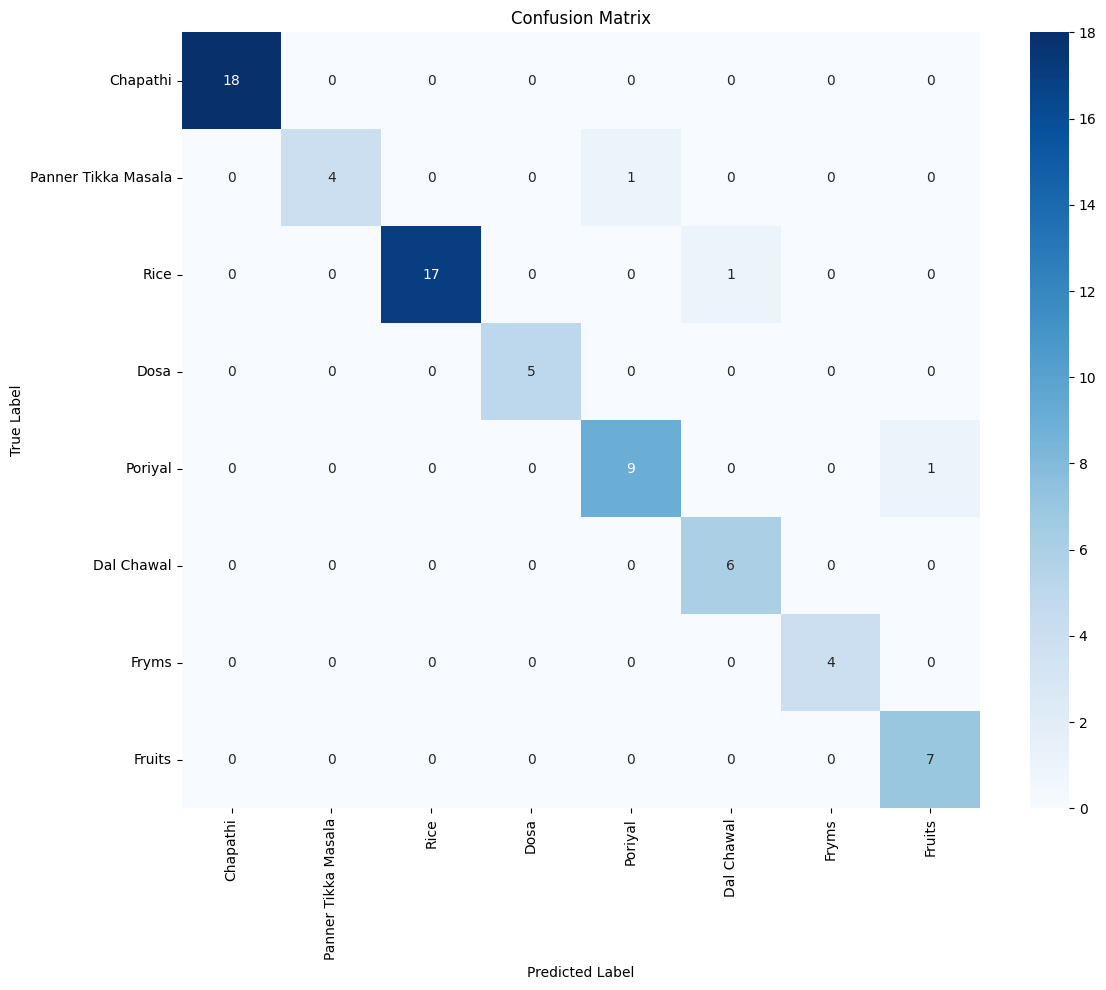

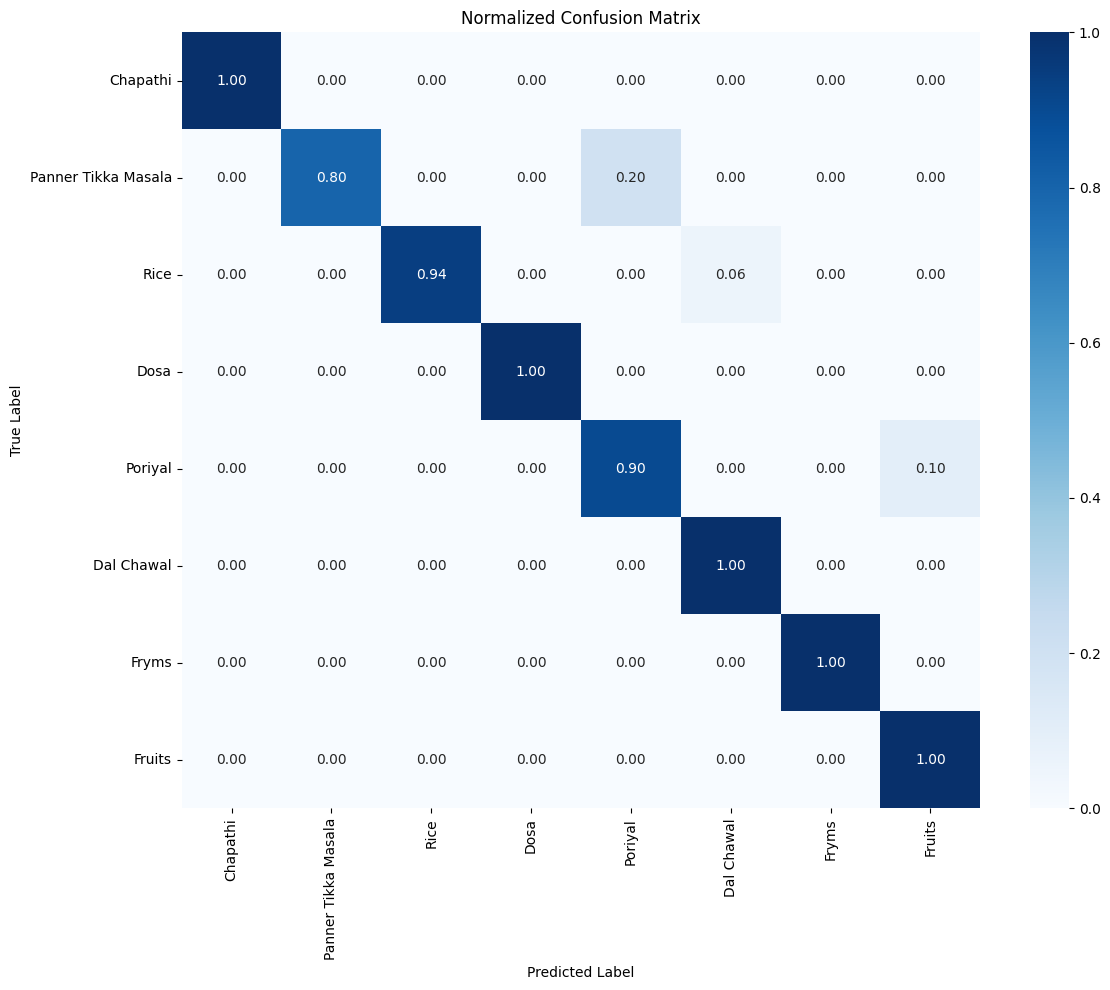

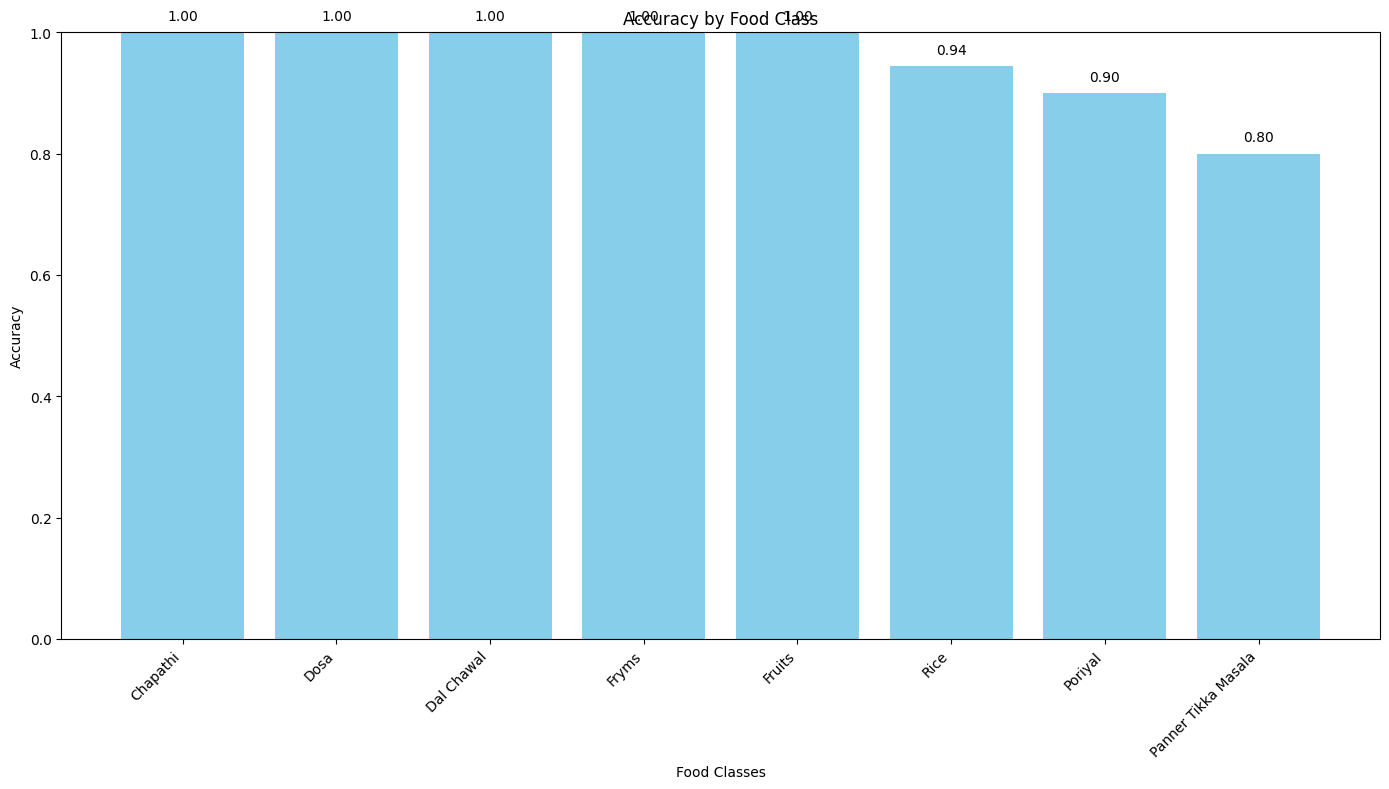

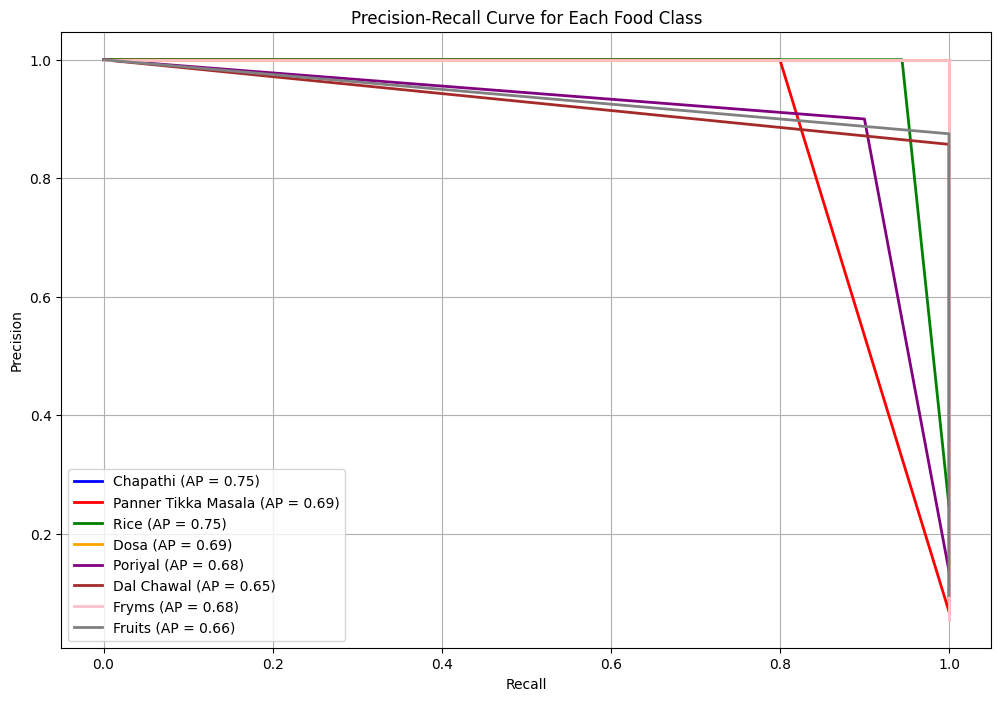


===== ERROR ANALYSIS =====
Found 3 misclassified images


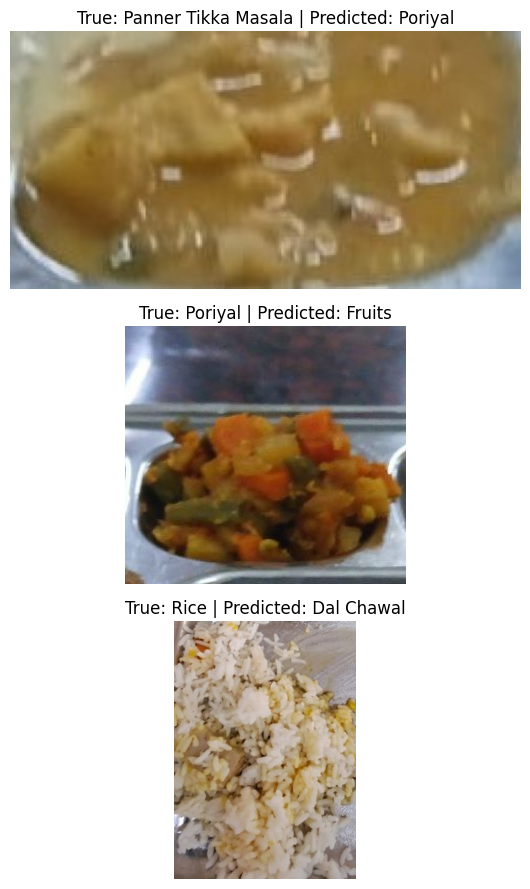

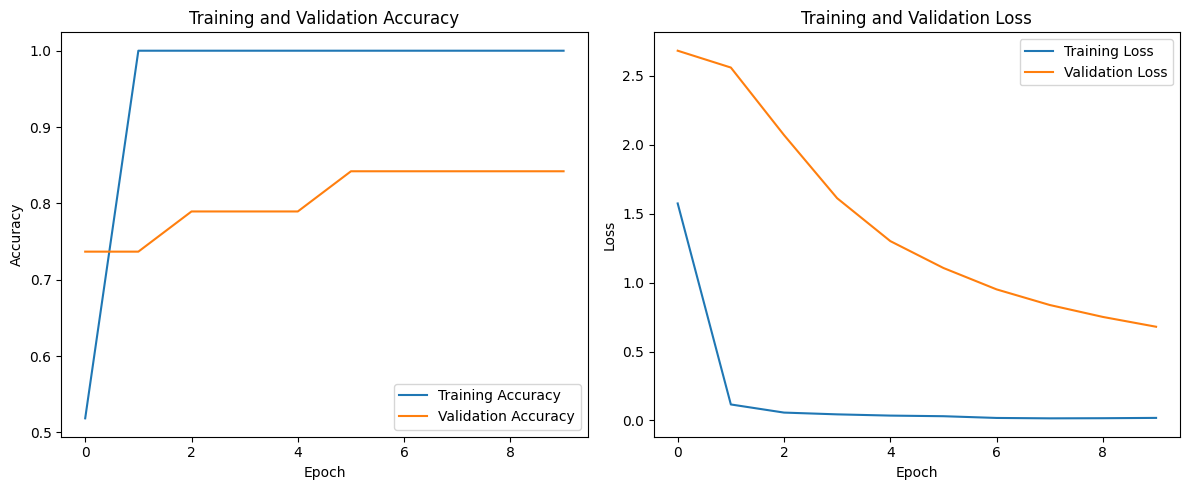


===== PREDICTION TIME ANALYSIS =====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted class index: 6
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted class index: 5
Confidence: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted class index: 7
Confidence: 98.09%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted class index: 6
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted class index: 6
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted class index: 3
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted class index: 3
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted class index: 4
Confidence: 98.44%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class index: 3
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted class index: 1
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class index: 0
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted clas

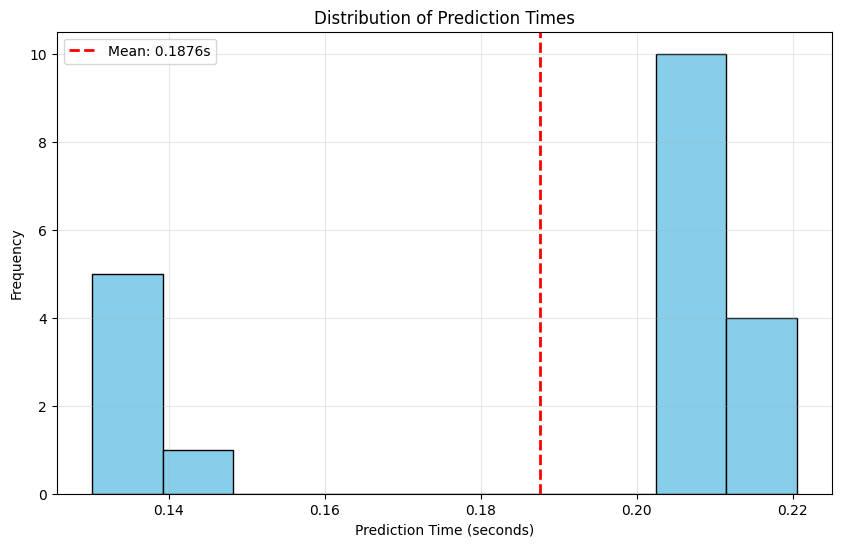


Evaluation complete!


In [ ]:
# Add this after the automated_food_waste_analysis function

"""Step 12: Model Evaluation and Performance Metrics"""

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from itertools import cycle

def evaluate_model_performance():
    """
    Evaluate the food detection model's performance using various metrics and visualizations.
    This function assumes you have ground truth labels for comparison.
    """
    print("===== MODEL EVALUATION AND PERFORMANCE METRICS =====")

    # Ask user for test data path that contains labeled images
    test_data_path = input("Enter the path to the folder containing labeled test images: ")

    if not os.path.exists(test_data_path) or not os.path.isdir(test_data_path):
        print(f"Error: The path '{test_data_path}' does not exist or is not a directory.")
        return

    # Get ground truth from folder structure
    # Assuming images are organized in subfolders named after their classes
    true_labels = []
    predicted_labels = []
    image_paths = []
    class_names = os.listdir(test_data_path)
    class_names = [c for c in class_names if os.path.isdir(os.path.join(test_data_path, c))]

    print(f"Found {len(class_names)} classes: {', '.join(class_names)}")

    # Process all images and collect predictions
    for class_name in class_names:
        class_dir = os.path.join(test_data_path, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg'))]

        print(f"Processing {len(image_files)} images for class '{class_name}'...")

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image_paths.append(image_path)

            try:
                # Get model prediction
                predicted_food = predict_image(image_path, saved_model)

                # Store true and predicted labels
                true_labels.append(class_name)
                predicted_labels.append(predicted_food)

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    # Convert labels to numerical form for some metrics
    label_to_id = {label: i for i, label in enumerate(set(true_labels).union(set(predicted_labels)))}
    id_to_label = {i: label for label, i in label_to_id.items()}

    y_true = np.array([label_to_id[label] for label in true_labels])
    y_pred = np.array([label_to_id.get(label, -1) for label in predicted_labels])

    # Filter out predictions that don't match any known class
    valid_indices = y_pred != -1
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]

    if len(y_true) == 0:
        print("No valid predictions found. Please check your test data.")
        return

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)

    # Convert to binary/multiclass format for sklearn functions
    y_true_bin = np.array([[1 if i == j else 0 for j in range(len(label_to_id))] for i in y_true])
    y_pred_bin = np.array([[1 if i == j else 0 for j in range(len(label_to_id))] for i in y_pred])

    # Calculate metrics for each class
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print overall metrics
    print("\n===== OVERALL PERFORMANCE METRICS =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print classification report
    print("\n===== CLASSIFICATION REPORT =====")
    class_labels = [id_to_label[i] for i in range(len(label_to_id))]
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Create confusion matrix
    print("\n===== CONFUSION MATRIX =====")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Create normalized confusion matrix
    plt.figure(figsize=(12, 10))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Create bar chart of class accuracies
    class_accuracies = []
    for i in range(len(label_to_id)):
        class_indices = y_true == i
        if np.sum(class_indices) > 0:
            class_acc = accuracy_score(y_true[class_indices], y_pred[class_indices])
            class_accuracies.append((id_to_label[i], class_acc))

    class_accuracies.sort(key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(14, 8))
    plt.bar([x[0] for x in class_accuracies], [x[1] for x in class_accuracies], color='skyblue')
    plt.xlabel('Food Classes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Food Class')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    for i, (_, acc) in enumerate(class_accuracies):
        plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')
    plt.tight_layout()
    plt.show()

    # Create precision-recall curve for each class
    plt.figure(figsize=(12, 8))

    for i, color in zip(range(len(label_to_id)), cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
        average_precision = np.mean(precision)
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'{id_to_label[i]} (AP = {average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Food Class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Error analysis - show examples of misclassified images
    print("\n===== ERROR ANALYSIS =====")
    misclassified_indices = np.where(y_true != y_pred)[0]

    if len(misclassified_indices) > 0:
        print(f"Found {len(misclassified_indices)} misclassified images")

        # Show up to 10 misclassified examples
        num_examples = min(10, len(misclassified_indices))
        plt.figure(figsize=(15, num_examples * 3))

        for i, idx in enumerate(misclassified_indices[:num_examples]):
            img_path = image_paths[idx]
            true_label = id_to_label[y_true[idx]]
            pred_label = id_to_label[y_pred[idx]]

            img = PILImage.open(img_path)
            plt.subplot(num_examples, 1, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label} | Predicted: {pred_label}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No misclassifications found!")

    # Create learning curve (if training history is available)
    try:
        if 'trained_model' in globals() and hasattr(trained_model, 'history'):
            history = trained_model.history

            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(history['accuracy'], label='Training Accuracy')
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(history['loss'], label='Training Loss')
            plt.plot(history['val_loss'], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Could not generate learning curves: {e}")

    # Calculate and display prediction time statistics
    print("\n===== PREDICTION TIME ANALYSIS =====")

    import time
    prediction_times = []

    # Measure prediction time for 20 random images
    sample_indices = np.random.choice(len(image_paths), min(20, len(image_paths)), replace=False)

    for idx in sample_indices:
        img_path = image_paths[idx]

        try:
            start_time = time.time()
            _ = predict_image(img_path, saved_model)
            end_time = time.time()
            prediction_times.append(end_time - start_time)
        except Exception as e:
            print(f"Error timing prediction for {img_path}: {e}")

    if prediction_times:
        avg_time = np.mean(prediction_times)
        std_time = np.std(prediction_times)
        min_time = np.min(prediction_times)
        max_time = np.max(prediction_times)

        print(f"Average prediction time: {avg_time:.4f} seconds")
        print(f"Standard deviation: {std_time:.4f} seconds")
        print(f"Minimum prediction time: {min_time:.4f} seconds")
        print(f"Maximum prediction time: {max_time:.4f} seconds")

        # Create prediction time histogram
        plt.figure(figsize=(10, 6))
        plt.hist(prediction_times, bins=10, color='skyblue', edgecolor='black')
        plt.axvline(avg_time, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_time:.4f}s')
        plt.xlabel('Prediction Time (seconds)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Prediction Times')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    print("\nEvaluation complete!")

# Run model evaluation function
def run_evaluation():
    choice = input("Would you like to run model evaluation? (y/n): ")
    if choice.lower() == 'y':
        evaluate_model_performance()

# Call the evaluation function after running the automated analysis
run_evaluation()